In [ ]:
!pip install yfinance
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3e6b7835b2048c3dc84aacf263151da54c94751b9d374ed85e3a0c1289dd9c2f
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


[*********************100%***********************]  1 of 1 completed


Data shape: (3236, 8)
Date range: 2011-02-22 00:00:00 to 2023-12-29 00:00:00
Columns: ['Open', 'High', 'Low', 'Close', 'RSI', 'MACD', 'MACD_signal', 'Returns']

Starting walk-forward test (RSI + MACD)...
Train period: 6 months (126 days)
Test period: 1 months (21 days)

--- Period 1 ---
Train: 2011-02-22 to 2011-08-19
Test:  2011-08-22 to 2011-09-20
Training agent...
Episode 0/50, Reward: -0.1988, Epsilon: 0.995
Episode 10/50, Reward: -0.2248, Epsilon: 0.946
Episode 20/50, Reward: -0.1409, Epsilon: 0.900
Episode 30/50, Reward: 0.2632, Epsilon: 0.856
Episode 40/50, Reward: 0.4815, Epsilon: 0.814
Test profit: 0.0217
Number of trades: 1

--- Period 2 ---
Train: 2011-03-23 to 2011-09-20
Test:  2011-09-21 to 2011-10-19
Training agent...
Episode 0/50, Reward: 0.0004, Epsilon: 0.995
Episode 10/50, Reward: 0.1818, Epsilon: 0.946
Episode 20/50, Reward: 0.4013, Epsilon: 0.900
Episode 30/50, Reward: 0.1826, Epsilon: 0.856
Episode 40/50, Reward: 0.0968, Epsilon: 0.814
Test profit: 0.0049
Number of

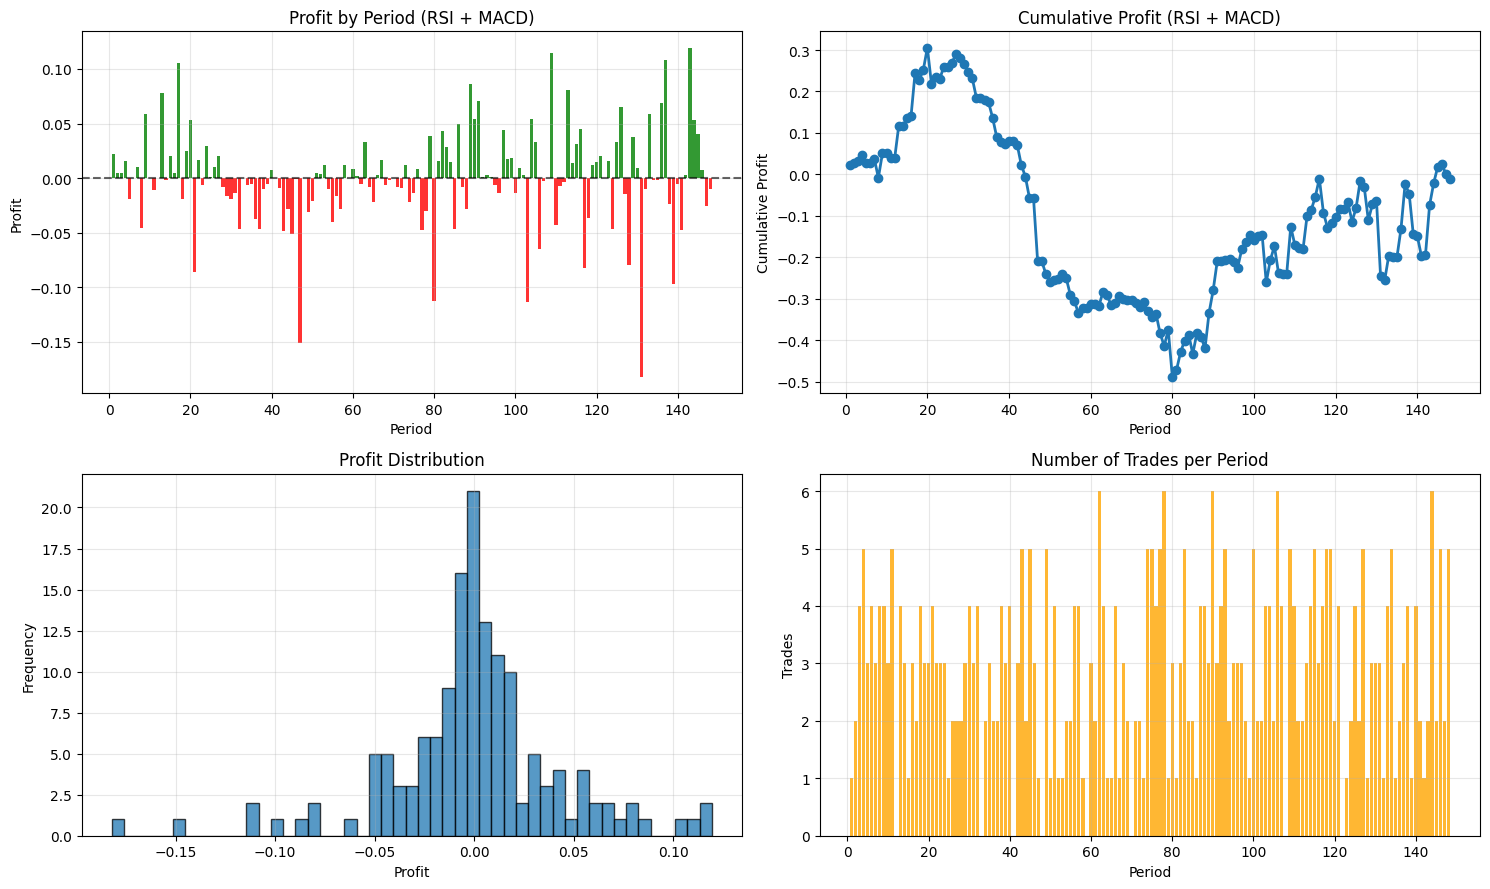


📊 Chart saved as results/indicators_rsi_macd_results.png


In [ ]:
# -----------------------------
# Deep Q-Learning Trading Agent
# OHLC + RSI + MACD Features (Consistent + CSV Saving)
# -----------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import warnings
import ta   # pip install ta
import os
warnings.filterwarnings('ignore')

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -----------------------------
# Config
# -----------------------------
TICKER = "GOOG"
START_DATE = "2011-01-01"
END_DATE = "2023-12-31"
STATE_WINDOW = 10
TRAIN_MONTHS = 6
TEST_MONTHS = 1
EPISODES = 50
BATCH_SIZE = 32
LR = 0.001
GAMMA = 0.95
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

# -----------------------------
# Download Data & Add Indicators
# -----------------------------
print("Downloading data...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]
df = df[['Open', 'High', 'Low', 'Close']].copy()

# Technical Indicators
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

# Clean
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print("Columns:", df.columns.tolist())

# -----------------------------
# Trading Environment
# -----------------------------
class TradingEnv:
    def __init__(self, data, window=STATE_WINDOW):
        self.data = data
        self.window = window
        self.reset()

    def reset(self):
        self.current_step = self.window
        self.position = 0           # 0 flat, 1 long, -1 short
        self.entry_price = 0.0
        self.total_profit = 0.0
        self.trades = []
        return self._get_state()

    def _get_state(self):
        if self.current_step >= len(self.data):
            return np.zeros(self.window * 7 + 1)  # 4 OHLC + 3 indicators
        features = self.data[['Open', 'High', 'Low', 'Close',
                               'RSI', 'MACD', 'MACD_signal']] \
                    .iloc[self.current_step - self.window:self.current_step].values
        norm = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-8)
        state = norm.flatten()
        return np.append(state, self.position)

    def step(self, action):
        if self.current_step >= len(self.data):
            return self._get_state(), 0.0, True
        reward = 0.0
        current_price = float(self.data.iloc[self.current_step]['Close'])
        transaction_cost = 0.001

        # 0 Hold, 1 Buy, 2 Sell
        if action == 1:
            if self.position == 0:
                self.position = 1; self.entry_price = current_price
                reward = -transaction_cost
            elif self.position == -1:
                profit = (self.entry_price - current_price) / self.entry_price
                reward = profit - transaction_cost
                self.total_profit += reward
                self.trades.append(('close_short', profit))
                self.position = 1; self.entry_price = current_price
        elif action == 2:
            if self.position == 0:
                self.position = -1; self.entry_price = current_price
                reward = -transaction_cost
            elif self.position == 1:
                profit = (current_price - self.entry_price) / self.entry_price
                reward = profit - transaction_cost
                self.total_profit += reward
                self.trades.append(('close_long', profit))
                self.position = -1; self.entry_price = current_price
        elif action == 0:
            if self.position == 1:
                reward = ((current_price - self.entry_price) / self.entry_price) * 0.1
            elif self.position == -1:
                reward = ((self.entry_price - current_price) / self.entry_price) * 0.1

        self.current_step += 1
        done = self.current_step >= len(self.data)
        # (Optional close at end is handled in other scripts; we leave consistent behavior here)
        return self._get_state(), float(reward), done

# -----------------------------
# DQN Model
# -----------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# -----------------------------
# Train Agent
# -----------------------------
def train_agent(train_data):
    state_dim = STATE_WINDOW * 7 + 1  # 7 features + position
    action_dim = 3
    env = TradingEnv(train_data)
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_SIZE)
    epsilon = EPSILON_START

    print("Training agent...")
    for ep in range(EPISODES):
        state = env.reset()
        episode_reward = 0.0
        done = False
        while not done:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    action = torch.argmax(policy_net(torch.tensor(state, dtype=torch.float32))).item()
            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(memory) >= BATCH_SIZE:
                states, actions, rewards, next_states, dones = zip(*memory.sample(BATCH_SIZE))
                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target = rewards + (GAMMA * next_q_values * (1 - dones))

                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if ep % 10 == 0:
            print(f"Episode {ep}/{EPISODES}, Reward: {episode_reward:.4f}, Epsilon: {epsilon:.3f}")

    return policy_net

# -----------------------------
# Test Agent
# -----------------------------
def test_agent(test_data, trained_model):
    env = TradingEnv(test_data)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action = torch.argmax(trained_model(torch.tensor(state, dtype=torch.float32))).item()
        next_state, reward, done = env.step(action)
        state = next_state
    return float(env.total_profit), len(env.trades)

# -----------------------------
# Walk-Forward
# -----------------------------
def run_walk_forward_test():
    results = []
    start_idx = 0
    days_per_month = 21
    train_days = TRAIN_MONTHS * days_per_month
    test_days = TEST_MONTHS * days_per_month
    period = 0

    print(f"\nStarting walk-forward test (RSI + MACD)...")
    print(f"Train period: {TRAIN_MONTHS} months ({train_days} days)")
    print(f"Test period: {TEST_MONTHS} months ({test_days} days)")

    while True:
        train_end_idx = start_idx + train_days
        test_end_idx = train_end_idx + test_days
        if test_end_idx >= len(df):
            break
        period += 1
        train_data = df.iloc[start_idx:train_end_idx].copy()
        test_data = df.iloc[train_end_idx:test_end_idx].copy()

        print(f"\n--- Period {period} ---")
        print(f"Train: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
        print(f"Test:  {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")

        model = train_agent(train_data)
        profit, trades = test_agent(test_data, model)

        print(f"Test profit: {profit:.4f}")
        print(f"Number of trades: {trades}")

        results.append({
            'period': period,
            'profit': profit,
            'num_trades': trades,
            'train_start': train_data.index[0],
            'train_end': train_data.index[-1],
            'test_start': test_data.index[0],
            'test_end': test_data.index[-1]
        })

        start_idx += test_days

    return results

# -----------------------------
# Save Results to CSV
# -----------------------------
def save_results_to_csv(results, filename="results_indicators_rsi_macd.csv"):
    os.makedirs("results", exist_ok=True)
    df_results = pd.DataFrame(results)

    profits = [r['profit'] for r in results]
    summary = {
        "total_periods": len(results),
        "total_profit": float(np.sum(profits)),
        "avg_profit": float(np.mean(profits)),
        "win_rate": float(len([p for p in profits if p > 0]) / len(profits) * 100) if len(profits) else 0.0,
        "best_period": float(np.max(profits)) if len(profits) else 0.0,
        "worst_period": float(np.min(profits)) if len(profits) else 0.0
    }

    detailed_path = os.path.join("results", filename.replace(".csv", "_detailed.csv"))
    summary_path  = os.path.join("results", filename.replace(".csv", "_summary.csv"))

    df_results.to_csv(detailed_path, index=False)
    pd.DataFrame([summary]).to_csv(summary_path, index=False)

    print(f"\n✅ Results saved to:\n  • {detailed_path}\n  • {summary_path}")

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    results = run_walk_forward_test()

    print("\n" + "="*60)
    print("WALK-FORWARD TEST RESULTS (RSI + MACD)")
    print("="*60)
    profits = [r['profit'] for r in results]
    total_profit = float(np.sum(profits))
    total_trades = int(np.sum([r['num_trades'] for r in results]))
    for r in results:
        print(f"Period {r['period']}: Profit = {r['profit']:.4f}, Trades = {r['num_trades']}")
    print(f"\nSUMMARY:")
    print(f"Total periods: {len(results)}")
    print(f"Total profit: {total_profit:.4f}")
    print(f"Average profit per period: {float(np.mean(profits)):.4f}")
    print(f"Total trades: {total_trades}")
    print(f"Win rate: {len([p for p in profits if p > 0]) / len(profits) * 100:.1f}%")
    print(f"Best period: {max(profits):.4f}")
    print(f"Worst period: {min(profits):.4f}")

    # Save CSVs
    save_results_to_csv(results, "results_indicators_rsi_macd.csv")

    # Plots
    periods = [r['period'] for r in results]
    trades_per_period = [r['num_trades'] for r in results]
    cumulative_profit = np.cumsum(profits)

    plt.figure(figsize=(15, 9))

    # Profit by period
    plt.subplot(2, 2, 1)
    plt.bar(periods, profits, color=['green' if p > 0 else 'red' for p in profits], alpha=0.8)
    plt.title('Profit by Period (RSI + MACD)')
    plt.xlabel('Period'); plt.ylabel('Profit')
    plt.axhline(0, color='black', linestyle='--', alpha=0.6)
    plt.grid(True, alpha=0.3)

    # Cumulative profit
    plt.subplot(2, 2, 2)
    plt.plot(periods, cumulative_profit, marker='o', linewidth=2)
    plt.title('Cumulative Profit (RSI + MACD)')
    plt.xlabel('Period'); plt.ylabel('Cumulative Profit')
    plt.grid(True, alpha=0.3)

    # Profit distribution
    plt.subplot(2, 2, 3)
    bins = max(3, len(profits) // 3)
    plt.hist(profits, bins=bins, edgecolor='black', alpha=0.75)
    plt.title('Profit Distribution')
    plt.xlabel('Profit'); plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Trades per period
    plt.subplot(2, 2, 4)
    plt.bar(periods, trades_per_period, color='orange', alpha=0.8)
    plt.title('Number of Trades per Period')
    plt.xlabel('Period'); plt.ylabel('Trades')
    plt.grid(True, alpha=0.3)

    os.makedirs("results", exist_ok=True)
    plt.tight_layout()
    plt.savefig("results/indicators_rsi_macd_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("\n📊 Chart saved as results/indicators_rsi_macd_results.png")
